In [1]:
import argparse
import json
import logging
import math
import os
import pickle
import random
import time
from datetime import datetime
from itertools import cycle
from tqdm import tqdm

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
import torchdyn
import wandb
from datasets import load_from_disk
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import issparse
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from utils.modules import MLPLayer, MidFC

In [2]:
with open('/home/dfl32/project/ifm/scalers/pcadim768_numsamples2000_minmax.pickle', 'rb') as f:
    scaler = pickle.load(f)

In [3]:
def mmd_rbf(X, Y, gamma=2.0, num_comps=50):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    XX = pairwise.rbf_kernel(X_red, X_red, gamma)
    YY = pairwise.rbf_kernel(Y_red, Y_red, gamma)
    XY = pairwise.rbf_kernel(X_red, Y_red, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def compute_wass(X, Y, reg=0.01, num_comps=50):
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    # Compute the cost matrix (squared Euclidean distances)
    M = ot.dist(X_red, Y_red, metric='sqeuclidean')
    
    # Normalize the cost matrix
    M /= M.max()
    
    # Assume uniform distribution of weights
    a = np.ones((X_red.shape[0],)) / X_red.shape[0]
    b = np.ones((Y_red.shape[0],)) / Y_red.shape[0]
    
    wasserstein_dist = ot.sinkhorn2(a, b, M, reg)
    return wasserstein_dist

def compute_gw(X, Y, num_comps=50):
    X_red = X[:, :num_comps]
    Y_red = Y[:, :num_comps]
    C1 = ot.dist(X_red, X_red, metric='euclidean')
    C2 = ot.dist(Y_red, Y_red, metric='euclidean')

    # Uniform distributions over samples
    p = ot.unif(X_red.shape[0])
    q = ot.unif(Y_red.shape[0])

    # Compute Gromov-Wasserstein distance
    gw_dist = ot.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return gw_dist

In [15]:
adata = sc.read_h5ad("/home/dfl32/project/ifm/cinemaot_data/raw_cinemaot.h5ad")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=20)

hvgs = adata.var['highly_variable']

if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

sample_indices = np.random.choice(expression_data.shape[0], size=5000, replace=False)
expression_data = expression_data[sample_indices]

# pca = PCA(n_components=768, svd_solver='randomized')
# pca.fit(expression_data)
# print("fit_done")

save_dir = "/home/dfl32/project/ifm/projections"
save_name = f"pcadim768_numsamples10000.pickle"
save_path = os.path.join(save_dir, save_name)
with open(save_path, 'rb') as f:
    pca = pickle.load(f)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [171]:
# save_dir = "/home/dfl32/project/ifm/projections"
# save_name = f"pcadim768_numsamples10000.pickle"
# save_path = os.path.join(save_dir, save_name)
# with open(save_path, 'wb') as f:
#     pickle.dump(pca, f)

In [13]:
dataset = load_from_disk("/home/dfl32/scratch/cinemaot_data/ifm_hf_ds/gaussian_pca768_normFalse_hf_ds")
data_array = np.array(dataset['expr'])

sample_indices = np.random.choice(data_array.shape[0], size=5000, replace=False)

# Subset the AnnData object
dense_array = data_array[sample_indices]

# # Convert to a dense matrix and extract the numpy array
# dense_array = sampled_adata.X.toarray() if issparse(sampled_adata.X) else sampled_adata.X

# Run inference

In [5]:
class DiffusionMLP(nn.Module):
    def __init__(self, denoising_time_steps):
        super(DiffusionMLP, self).__init__()
        self.time_embed = nn.Embedding(denoising_time_steps, 1024)  # 100 is the number of timesteps
        self.model = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 768)
        )
    
    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = self.model[0](x) + t_embed
        x = self.model[1](x)
        for layer in self.model[2:]:
            x = layer(x)
        return x

class DiffusionFC(nn.Module):
    def __init__(self, intermediate_dim=1024, num_fc_layers=2, denoising_time_steps=100):
        super(DiffusionFC, self).__init__()
        self.time_embed = nn.Embedding(denoising_time_steps, intermediate_dim)
        self.model = nn.Sequential(
            nn.Linear(768, intermediate_dim),
            MidFC(dim=intermediate_dim, num_layers=num_fc_layers),
            nn.Linear(intermediate_dim, 768)
        )
    
    def forward(self, x, t):
        t_embed = self.time_embed(t)
        x = self.model[0](x) + t_embed
        for layer in self.model[1:]:
            x = layer(x)
        return x


class DDPM:
    def __init__(self, model, device, num_timesteps=100, beta_start=0.0001, beta_end=0.02):
        self.model = model
        self.device = device
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)

    def sample_timesteps(self, batch_size):
        return torch.randint(0, self.num_timesteps, (batch_size,)).to(self.device)

    def forward_diffusion(self, x_0, t):
        alpha_bars_t = self.alpha_bars[t].unsqueeze(1)
        print(alpha_bars_t)
        noise = torch.randn_like(x_0).to(self.device)
        x_t = torch.sqrt(alpha_bars_t) * x_0 + torch.sqrt(1 - alpha_bars_t) * noise
        return x_t, noise

    def denoise_step(self, x, t):
        alpha_bars_t = self.alpha_bars[t].unsqueeze(1)
        beta_t = self.betas[t].unsqueeze(1)
        alpha_t = self.alphas[t].unsqueeze(1)
        noise = torch.randn_like(x).to(self.device)
        added_noise = (torch.sqrt(beta_t)*noise)
        noise_pred = self.model(x, t)
        noise_pred_coeff = (1-alpha_t)/torch.sqrt(1 - alpha_bars_t)
        x_prev = (x - noise_pred_coeff * noise_pred) / torch.sqrt(alpha_t)
        x_prev = x_prev + added_noise
        return x_prev

    def denoise(self, x):
        x_t = x
        for t in range(self.num_timesteps-1, -1, -1):
            t_tensor = torch.tensor([t], dtype=torch.long).to(x.device)
            x_t = self.denoise_step(x_t, t_tensor)
        return x_t

    def loss(self, x_0):
        batch_size = x_0.shape[0]
        t = self.sample_timesteps(batch_size).to(x_0.device)
        x_t, noise = self.forward_diffusion(x_0, t)
        noise_pred = self.model(x_t, t)
        return nn.MSELoss()(noise_pred, noise)

In [6]:
model_dir = "/home/dfl32/scratch/training-runs/simple_ifm/diffusion-2024-05-19_13-31-26"
checkpoint = 1000000
model_path = os.path.join(model_dir, f"checkpoint-{checkpoint}.pt")
device = torch.device("cuda")


denoising_time_steps = 1000
intermediate_dim = 2048
num_fc_layers = 1
model = DiffusionFC(
    intermediate_dim=intermediate_dim,
    denoising_time_steps=denoising_time_steps,
    num_fc_layers=num_fc_layers
).to(device)
print(model.load_state_dict(torch.load(model_path)))
model.eval()
ddpm = DDPM(model, device, num_timesteps=denoising_time_steps)

<All keys matched successfully>


In [7]:
torch.sqrt(ddpm.betas)

tensor([0.0100, 0.0110, 0.0118, 0.0126, 0.0134, 0.0141, 0.0148, 0.0155, 0.0161,
        0.0167, 0.0173, 0.0179, 0.0184, 0.0189, 0.0195, 0.0200, 0.0205, 0.0209,
        0.0214, 0.0219, 0.0223, 0.0228, 0.0232, 0.0236, 0.0240, 0.0245, 0.0249,
        0.0253, 0.0256, 0.0260, 0.0264, 0.0268, 0.0272, 0.0275, 0.0279, 0.0282,
        0.0286, 0.0289, 0.0293, 0.0296, 0.0299, 0.0303, 0.0306, 0.0309, 0.0312,
        0.0316, 0.0319, 0.0322, 0.0325, 0.0328, 0.0331, 0.0334, 0.0337, 0.0340,
        0.0343, 0.0346, 0.0349, 0.0351, 0.0354, 0.0357, 0.0360, 0.0363, 0.0365,
        0.0368, 0.0371, 0.0373, 0.0376, 0.0379, 0.0381, 0.0384, 0.0387, 0.0389,
        0.0392, 0.0394, 0.0397, 0.0399, 0.0402, 0.0404, 0.0407, 0.0409, 0.0412,
        0.0414, 0.0416, 0.0419, 0.0421, 0.0423, 0.0426, 0.0428, 0.0430, 0.0433,
        0.0435, 0.0437, 0.0440, 0.0442, 0.0444, 0.0446, 0.0449, 0.0451, 0.0453,
        0.0455, 0.0457, 0.0460, 0.0462, 0.0464, 0.0466, 0.0468, 0.0470, 0.0472,
        0.0474, 0.0477, 0.0479, 0.0481, 

In [8]:
# Denoising function
# def denoise(model, ddpm, x_noisy, num_steps=100):
#     model.eval()
#     x = x_noisy.clone().detach()
#     for t in range(num_steps-1, -1, -1):
#         t_tensor = torch.tensor([t], dtype=torch.long).to(x.device)
#         x_t = ddpm.forward_diffusion(x, t_tensor)[0]
#         x = model(x_t, t_tensor)
#     return x

batch_size = 100
num_steps = 50

cells = []

unscale = True
with torch.no_grad():
    for step in tqdm(range(num_steps)):
        x_noisy = torch.randn(batch_size, 768).to(device)  # Replace with your noisy input
        x_denoised = ddpm.denoise(x_noisy)
        if unscale:
            x_denoised = scaler.inverse_transform(x_denoised.cpu().numpy())
        else:
            x_denoised = x_denoised.cpu().numpy()
        cells.append(x_denoised)
    cells = np.concatenate(cells, axis=0)

100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


In [9]:
cells_ag = pca.inverse_transform(cells)

In [18]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_statistics(array1, array2):
    # Ensure the arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The input arrays must have the same shape.")
    
    # Calculate row-wise means
    mean1 = np.mean(array1, axis=0)
    mean2 = np.mean(array2, axis=0)
    
    # Calculate R^2
    correlation_matrix = np.corrcoef(mean1, mean2)
    r2 = correlation_matrix[0, 1] ** 2
    
    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(mean1, mean2)
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(mean1, mean2)
    
    return r2, pearson_corr, spearman_corr


r2, pearson_corr, spearman_corr = compute_statistics(cells_ag, expression_data)
print(f"R^2: {r2}")
print(f"Pearson correlation: {pearson_corr}")
print(f"Spearman correlation: {spearman_corr}")


R^2: 0.9705430464816436
Pearson correlation: 0.9851614316860252
Spearman correlation: 0.9754026218036217


In [14]:
r2, pearson_corr, spearman_corr = compute_statistics(cells, dense_array)
print(f"PCA R^2: {r2}")
print(f"PCA Pearson correlation: {pearson_corr}")
print(f"PCA Spearman correlation: {spearman_corr}")

PCA R^2: 0.3753429920906756
PCA Pearson correlation: 0.6126524235573321
PCA Spearman correlation: -0.002115730058000451


In [17]:
r2, pearson_corr, spearman_corr = compute_statistics(cells_ag[:, hvgs], expression_data[:, hvgs])
print(f"HVGS R^2: {r2}")
print(f"HVGS Pearson correlation: {pearson_corr}")
print(f"HVGS Spearman correlation: {spearman_corr}")

HVGS R^2: 0.8707564005677125
HVGS Pearson correlation: 0.9331432904799304
HVGS Spearman correlation: 0.9052631578947368


In [20]:
pcs = [i for i in range(10, 101, 10)]
for pc in pcs:
    # mmd = mmd_rbf(cells, dense_array, gamma=0.01, num_comps=pc)
    # print(f"PCS {pc} MMD {mmd}")
# for pc in pcs:
#     wass = compute_wass(cells, dense_array, num_comps=pc)
#     print(f"PCS {pc} Wass {wass}")
# for pc in pcs:
    wass = compute_gw(cells, dense_array, num_comps=pc)
    print(f"PCS {pc} GW {wass}")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


PCS 10 GW 203715.65557529396


KeyboardInterrupt: 

In [10]:
diff_adata = anndata.AnnData(X=cells)
diff_adata.obs['sample'] = ['diffusion']*len(cells)
simple_sampled_adata = anndata.AnnData(X=dense_array)
simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
combined_norm_adata = anndata.concat([simple_sampled_adata, diff_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


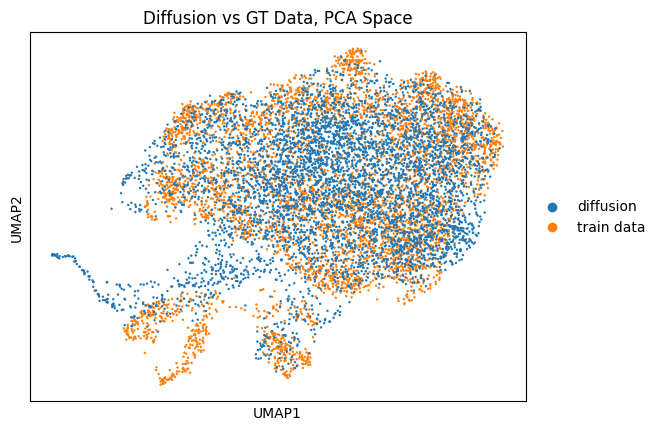

In [11]:
sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['sample'], wspace=0.5, title="Diffusion vs GT Data, PCA Space")

In [179]:
print(f"MMD {mmd_rbf(diff_adata.X, simple_sampled_adata.X)}")
print(f"Wass {compute_wass(diff_adata.X, simple_sampled_adata.X)}")

MMD 0.000399999994947575
Wass 0.0008025382177796735


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


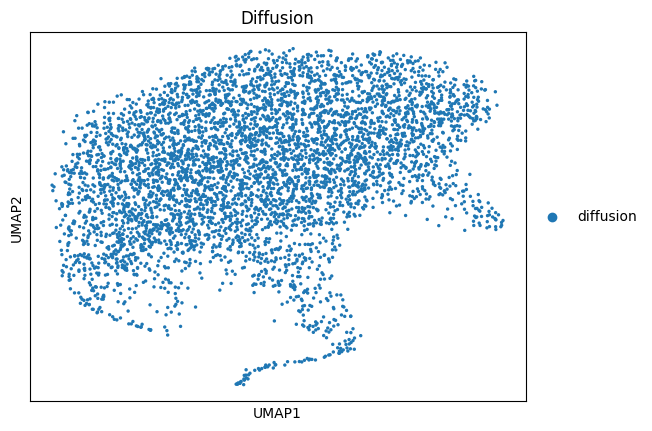

In [178]:
sc.pp.pca(diff_adata)
sc.pp.neighbors(diff_adata)
sc.tl.umap(diff_adata)
sc.pl.umap(diff_adata, color=['sample'], wspace=0.5, title="Diffusion")

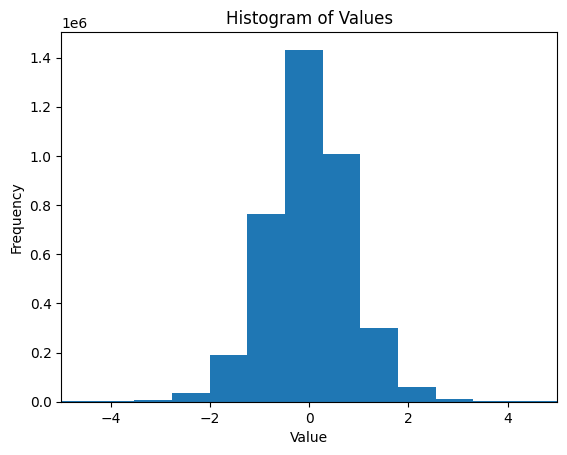

In [180]:
import matplotlib.pyplot as plt

# Assuming 'diff_adata' is an AnnData object and 'values' is the data we want to plot
values = diff_adata.X.flatten()  # Flatten if diff_adata.X is a matrix

# Plot histogram
plt.hist(values, bins=10000)
plt.xlim(-5,5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()


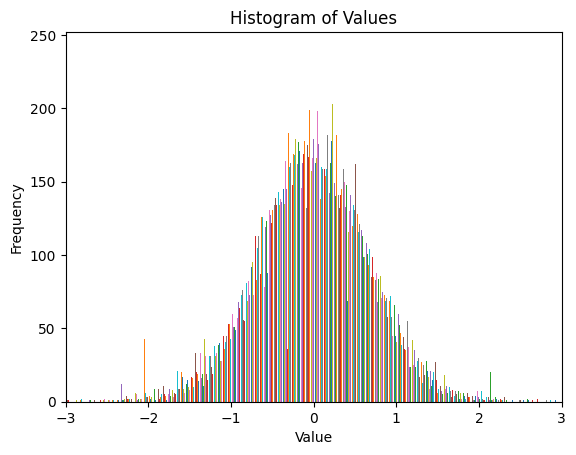

In [169]:
import matplotlib.pyplot as plt

# Assuming 'diff_adata' is an AnnData object and 'values' is the data we want to plot
values = simple_sampled_adata.X  # Flatten if diff_adata.X is a matrix

# Plot histogram
plt.hist(values, bins=1000)
plt.xlim(-3,3)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

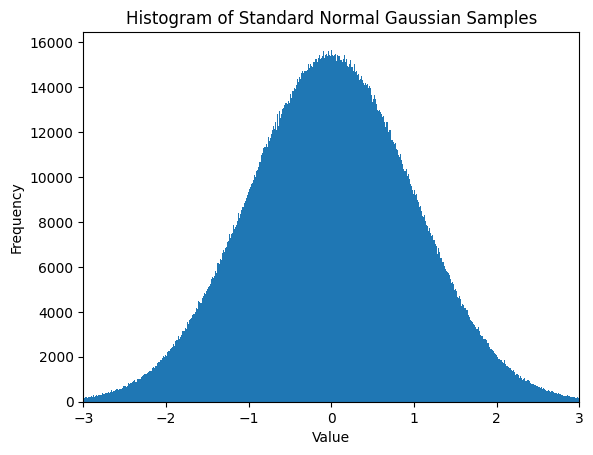

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 768 * 5000 samples from a standard normal Gaussian
samples = np.random.randn(768 * 5000)

# Plot histogram
plt.hist(samples, bins=1000)
plt.xlim(-3,3)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Normal Gaussian Samples')
plt.show()


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


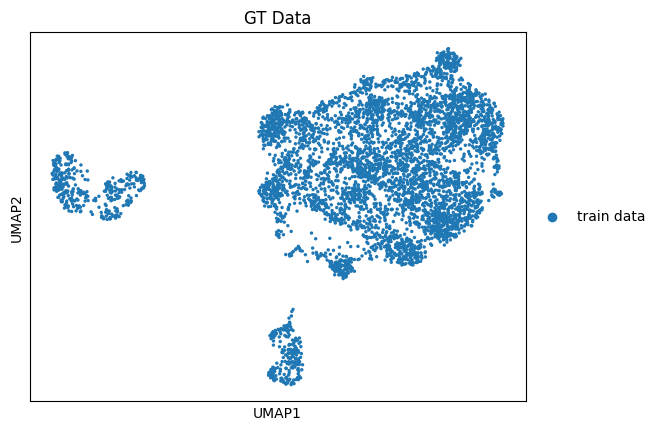

In [14]:
sc.pp.pca(simple_sampled_adata)
sc.pp.neighbors(simple_sampled_adata)
sc.tl.umap(simple_sampled_adata)
sc.pl.umap(simple_sampled_adata, color=['sample'], wspace=0.5, title="GT Data")